# Data Preprocessing – PlantVillage

This notebook prepares the dataset for model training by
applying transformations, normalization, and data loading.


In [14]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler


In [21]:

base_path = "PlantVillage" 
train_path = os.path.join(base_path, "train")
val_path = os.path.join(base_path, "val")
classes = sorted(os.listdir(train_path))
print("Classes loaded:", len(classes))
print("Train path:", train_path)
print("Val path:", val_path)


Classes loaded: 38
Train path: PlantVillage\train
Val path: PlantVillage\val


Define Image Transformations


In [22]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])])

val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])


Load Dataset Using ImageFolder


In [23]:
train_dataset = datasets.ImageFolder(train_path, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_path, transform=val_transforms)
print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))
print("Number of classes:", len(train_dataset.classes))


Train samples: 43444
Val samples: 10861
Number of classes: 38


Dataset Integrity Check

In [24]:
empty_classes = [cls for cls in classes if len(os.listdir(os.path.join(train_path, cls))) == 0]
print("Empty classes:", empty_classes)
train_images = set()
for cls in classes:
    train_images.update(os.listdir(os.path.join(train_path, cls)))
val_images = set()
for cls in classes:
    val_images.update(os.listdir(os.path.join(val_path, cls)))
print("Train-Val overlap:", len(train_images & val_images))


Empty classes: []
Train-Val overlap: 0


 Handle Class Imbalance


In [25]:
class_counts = np.bincount(train_dataset.targets)
class_weights = 1. / class_counts
sample_weights = class_weights[train_dataset.targets]
sampler = WeightedRandomSampler(sample_weights,len(sample_weights),replacement=True)


 Creating  DataLoaders


In [26]:

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    sampler=sampler,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)


Data Augmentation Visualization


In [27]:

def denormalize(img):
    mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    std = torch.tensor([0.229,0.224,0.225]).view(3,1,1)
    return img * std + mean


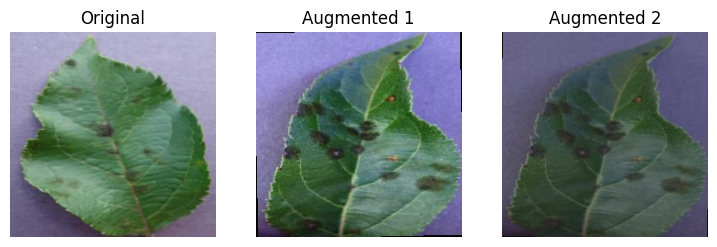

In [28]:
orig_img, _ = val_dataset[0]
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plt.imshow(denormalize(orig_img).permute(1,2,0).clamp(0,1))
plt.title("Original")
plt.axis("off")
for i in range(2):
    aug_img, _ = train_dataset[0]
    plt.subplot(1,3,i+2)
    plt.imshow(denormalize(aug_img).permute(1,2,0).clamp(0,1))
    plt.title(f"Augmented {i+1}")
    plt.axis("off")
plt.show()


Final Sample Visualization


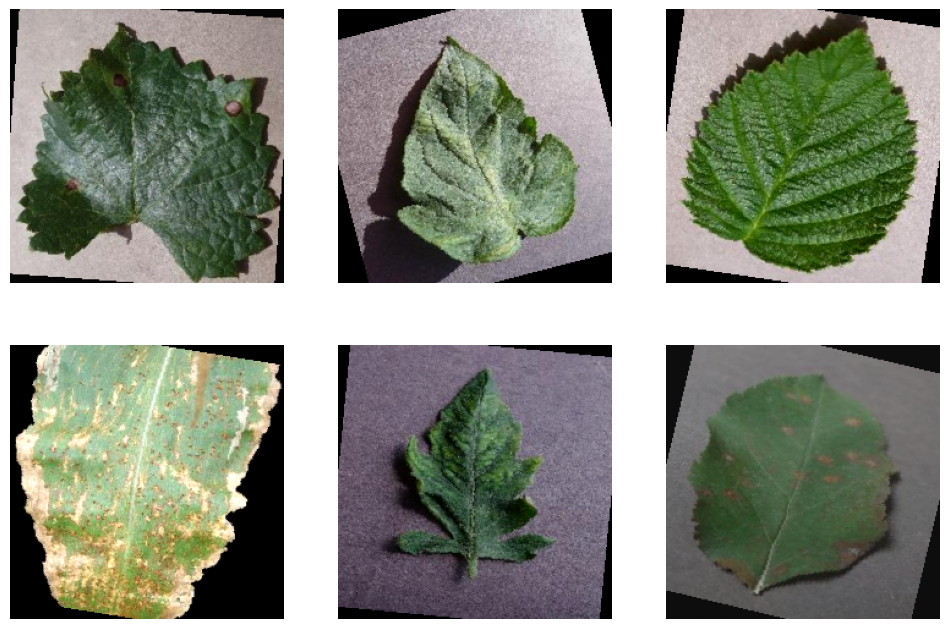

In [ ]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(denormalize(images[i]).permute(1,2,0).clamp(0,1))
    plt.axis("off")
plt.show()
